## **TMDB Movie Dataset EDA**

### ***Importing Data and Libraries***

In [1]:
# Import libraries
import ast
import nltk
import string
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import TreebankWordTokenizer
from matplotlib.colors import LinearSegmentedColormap

# Initialize Plotly to run in offline mode in Jupyter notebooks
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [2]:
# Read data from csv file
credits = pd.read_csv('tmdb_5000_credits.csv', encoding="utf-8")
movies = pd.read_csv('tmdb_5000_movies.csv', encoding="utf-8")

### ***Cleaning Data and Extracting features from 'Credits' Dataset***

In [3]:
# Calculate the number of missing values in each column of the 'credits' DataFrame
credits.isna().sum()

movie_id    0
title       0
cast        0
crew        0
dtype: int64

In [4]:
# Select rows from the 'credits' DataFrame where there are duplicate rows
credits[credits.duplicated()]

Empty DataFrame
Columns: [movie_id, title, cast, crew]
Index: []

In [5]:
# Access the 'cast' column 
credits.cast

0       [{"cast_id": 242, "character": "Jake Sully", "...
1       [{"cast_id": 4, "character": "Captain Jack Spa...
2       [{"cast_id": 1, "character": "James Bond", "cr...
3       [{"cast_id": 2, "character": "Bruce Wayne / Ba...
4       [{"cast_id": 5, "character": "John Carter", "c...
                              ...                        
4798    [{"cast_id": 1, "character": "El Mariachi", "c...
4799    [{"cast_id": 1, "character": "Buzzy", "credit_...
4800    [{"cast_id": 8, "character": "Oliver O\u2019To...
4801    [{"cast_id": 3, "character": "Sam", "credit_id...
4802    [{"cast_id": 3, "character": "Herself", "credi...
Name: cast, Length: 4803, dtype: object

In [6]:
# Check the data type of the first element in the 'cast' column 
type(credits.cast[0])

str

In [7]:
# Convert string representations of Python data structures into actual Python objects
type(ast.literal_eval(credits.cast[0]))

list

In [8]:
credits.head()

movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
4  [{"credit_id": "52fe479ac3a36847f813eaa3", "de...

In [9]:
# Extract information from 'credits' dataset

# Define a function to extract unique departments from crew data
def extract_departments(row):
    crew = ast.literal_eval(row['crew'])
    return set(member['department'] for member in crew if 'department' in member)

# Define a function to count genders in cast and crew
def count_genders(row):
    cast = ast.literal_eval(row['cast'])
    crew = ast.literal_eval(row['crew'])
    
    # Count male, female, and unspecified genders in cast
    male_cast = sum(1 for actor in cast if actor.get('gender') == 2)
    female_cast = sum(1 for actor in cast if actor.get('gender') == 1)
    unspecified_cast = sum(1 for actor in cast if actor.get('gender') == 0)
    
    # Count male, female, and unspecified genders in crew
    male_crew = sum(1 for member in crew if member.get('gender') == 2)
    female_crew = sum(1 for member in crew if member.get('gender') == 1)
    unspecified_crew = sum(1 for member in crew if member.get('gender') == 0)

    # Get unique jobs
    unique_jobs = set(member['job'] for member in crew if 'job' in member)
    
    return male_cast, female_cast, unspecified_cast, male_crew, female_crew, unspecified_crew, len(unique_jobs)

# Get all unique departments across all movies
all_departments = set()
for index, row in credits.iterrows():
    all_departments.update(extract_departments(row))

# Define a function to create a dictionary of department presence
def create_department_presence(row):
    departments = extract_departments(row)
    department_presence = {department: 1 if department in departments else 0 for department in all_departments}
    return pd.Series(department_presence)

# Create columns for genders and jobs counts in cast and crew
credits[['Male_Cast', 'Female_Cast', 'Unspecified_Cast', 'Male_Crew', 'Female_Crew', 'Unspecified_Crew', 'Num_Jobs']] = credits.apply(count_genders, axis=1, result_type='expand')

# Count the number of unique departments in each row
credits['Num_Departments'] = credits.apply(lambda row: len(extract_departments(row)), axis=1)

# Create columns in a new dataframe for department presence
departments_df = credits.loc[:, ['movie_id', 'title']]
departments_df[list(all_departments)] = credits.apply(create_department_presence, axis=1)


In [10]:
# Create a new DataFrame 'df' by dropping the 'cast' and 'crew' columns
df = credits.drop(columns=['cast', 'crew'])
df['Num_Cast'] = df.iloc[:, 2:5].sum(axis=1)
df['Num_Crew'] = df.iloc[:, 5:8].sum(axis=1)
df.head()

movie_id                                     title  Male_Cast  Female_Cast  \
0     19995                                    Avatar         20           12   
1       285  Pirates of the Caribbean: At World's End         25            5   
2    206647                                   Spectre         55           13   
3     49026                     The Dark Knight Rises         73           11   
4     49529                               John Carter         19            6   

   Unspecified_Cast  Male_Crew  Female_Crew  Unspecified_Crew  Num_Jobs  \
0                51         28           10               115        57   
1                 4         15            8                 9        20   
2                15         25            4               126        62   
3                74         37            5               175        87   
4                 2         25            5               102        65   

   Num_Departments  Num_Cast  Num_Crew  
0               11        83       153  
1                9        34        32  
2               11        83       155  
3               11       158       217  
4               11        27       132

In [11]:
departments_df.head()

movie_id                                     title  Actors  Crew  \
0     19995                                    Avatar       0     1   
1       285  Pirates of the Caribbean: At World's End       0     1   
2    206647                                   Spectre       0     1   
3     49026                     The Dark Knight Rises       0     1   
4     49529                               John Carter       0     1   

   Directing  Lighting  Editing  Costume & Make-Up  Visual Effects  Writing  \
0          1         1        1                  1               1        1   
1          1         0        1                  1               0        1   
2          1         1        1                  1               1        1   
3          1         1        1                  1               1        1   
4          1         1        1                  1               1        1   

   Art  Production  Camera  Sound  
0    1           1       1      1  
1    1           1       1      1  
2    1           1       1      1  
3    1           1       1      1  
4    1           1       1      1

### ***Cleaning Data and Extracting features from 'movies' Dataset***

In [12]:
movies.isna().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

In [13]:
movies[movies.duplicated()]

Empty DataFrame
Columns: [budget, genres, homepage, id, keywords, original_language, original_title, overview, popularity, production_companies, production_countries, release_date, revenue, runtime, spoken_languages, status, tagline, title, vote_average, vote_count]
Index: []

In [14]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [15]:
# Convert the 'release_date' column  to datetime format
movies.release_date = pd.to_datetime(movies.release_date)

In [16]:
# Convert string representations of lists in selected columns to actual lists
for col in ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']:
    movies[col] = movies[col].apply(ast.literal_eval)

In [17]:
# Extract unique names from DataFrame columns of dictionaries
unique_genres = set([genre['name'].title() for row in movies['genres'] for genre in row])
unique_keywords = set([keyword['name'].title() for row in movies['keywords'] for keyword in row])
unique_pcm = set([company['name'].title() for row in movies['production_companies'] for company in row])
unique_pc = set([country['name'].title() for row in movies['production_countries'] for country in row])
unique_sl = set([language['name'].title() for row in movies['spoken_languages'] for language in row])

# Count unique words
print("Number of unique genres:", len(unique_genres))
print("Number of unique keywords:", len(unique_keywords))
print("Number of unique production_companies:", len(unique_pcm))
print("Number of unique production_countries:", len(unique_pc))
print("Number of unique spoken_languages:", len(unique_sl))

Number of unique genres: 20
Number of unique keywords: 9813
Number of unique production_companies: 5006
Number of unique production_countries: 88
Number of unique spoken_languages: 62


In [18]:
# Check for duplicated values in the 'id' column
movies[movies['id'].duplicated(keep=False)]['id']

Series([], Name: id, dtype: int64)

In [19]:
# Check if duplicate titles are identical
movies[movies['title'].duplicated(keep=False)].loc[:, ['title', 'original_title', 'release_date', 'runtime', 'tagline']]

title   original_title release_date  runtime  \
972          The Host         The Host   2013-03-22    125.0   
1359           Batman           Batman   1989-06-23    126.0   
2877         The Host               괴물   2006-07-27    119.0   
3647  Out of the Blue  Out of the Blue   1980-05-01     94.0   
3693  Out of the Blue  Out of the Blue   2006-10-12    103.0   
4267           Batman           Batman   1966-07-30    105.0   

                                                tagline  
972                               You will be one of us  
1359  Have you ever danced with the devil in the pal...  
2877                                 Monsters are real.  
3647  A harrowing drama from the director of Easy Rider  
3693            The true story of a small town massacre  
4267           He's Here Big As Life In A Real Bat-Epic

In [20]:
# Check if two columns are identical
identical = (movies['original_title'] == movies['title']).all()

if identical:
    print("\033[92mColumns are identical!\033[0m")
else:
    print("\033[91mColumns are not identical!\033[0m")

Columns are not identical!


In [21]:
# Display the last few rows where 'original_title' differs from 'title'
movies[movies['original_title'] != movies['title']].loc[:, ['original_title', 'title']].tail()

original_title              title
4699                                      Lumea e a mea  The World Is Mine
4719  Une femme mariée: Suite de fragments d'un film...  The Married Woman
4751                           Gabriela, Cravo e Canela           Gabriela
4790                                              دایره         The Circle
4792                                                キュア               Cure

In [22]:
movies.shape

(4803, 20)

#### ***Handling Missing Values and Detecting outliers***

In [23]:
# Fill missing values in 'homepage', 'overview', and 'tagline' columns with 'N/A', and remove any remaining rows with missing values
movies['homepage'] = movies['homepage'].fillna('N/A')
movies['overview'] = movies['overview'].fillna('N/A')
movies['tagline'] = movies['tagline'].fillna('N/A')
movies.dropna(inplace=True)

In [24]:
movies.shape

(4800, 20)

In [25]:
movies.isna().sum().sum()

0

#### *Checking columns*

#### *status*

In [26]:
# Count the frequency of each unique value in the 'status' column
movies.status.value_counts()

status
Released           4792
Rumored               5
Post Production       3
Name: count, dtype: int64

In [27]:
# Filter the 'movies' DataFrame to include only rows where the 'status' column is 'Released'
movies = movies[movies.status == 'Released']

#### *budget & revenue*

In [28]:
# Select rows where the column has values less than 0
movies[movies.budget < 0]

Empty DataFrame
Columns: [budget, genres, homepage, id, keywords, original_language, original_title, overview, popularity, production_companies, production_countries, release_date, revenue, runtime, spoken_languages, status, tagline, title, vote_average, vote_count]
Index: []

In [29]:
movies.shape

(4792, 20)

In [30]:
# Calculate the number of rows  where the column has a value of 0
len(movies[movies.budget == 0])

1031

In [31]:
movies[movies.revenue < 0]

Empty DataFrame
Columns: [budget, genres, homepage, id, keywords, original_language, original_title, overview, popularity, production_companies, production_countries, release_date, revenue, runtime, spoken_languages, status, tagline, title, vote_average, vote_count]
Index: []

In [32]:
len(movies[movies.revenue == 0])

1417

In [33]:
len(movies[(movies.budget == 0) & (movies.revenue > 0)])

147

In [34]:
len(movies[(movies.budget > 0) & (movies.revenue == 0)])

533

In [35]:
len(movies[(movies.budget == 0) & (movies.revenue == 0)])

884

In [36]:
len(movies) - len(movies[(movies.budget == 0) | (movies.revenue == 0)])

3228

In [37]:
# We treat values of zero in the budget field as missing (assumption)
movies = movies[movies.budget != 0]

In [38]:
movies.shape

(3761, 20)

#### *original_language*

In [39]:
# Unique values in the 'original_language' column
movies.original_language.unique()

array(['en', 'ja', 'fr', 'zh', 'es', 'ko', 'te', 'ru', 'de', 'cn', 'it',
       'nl', 'sv', 'th', 'da', 'xx', 'hi', 'is', 'tr', 'pt', 'nb', 'af',
       'pl', 'he', 'vi', 'id', 'ro', 'fa', 'no', 'ps'], dtype=object)

In [40]:
# Find the most common original language in the 'movies' DataFrame along with its count
movies.original_language.value_counts().idxmax(), movies.original_language.value_counts().max()

('en', 3580)

#### *homepage*

In [41]:
import re

# Function to check if a string is a valid website address
def is_website_address(url):
    # Regular expression pattern to match website addresses
    pattern = r'https?://(?:www\.)?[\w.-]+\.[a-zA-Z]{2,}(?:/\S*)?'
    return bool(re.match(pattern, url, re.IGNORECASE))

# Check if all rows in the 'homepage' column are valid website addresses
all_valid = movies[movies['homepage'] != 'N/A']['homepage'].astype(str).apply(is_website_address).all()

if all_valid:
    print("\033[92mAll rows in the 'Website' column are valid website addresses.\033[0m")
else:
    print("\033[91mSome rows in the 'Website' column are not valid website addresses.\033[0m")

All rows in the 'Website' column are valid website addresses.


#### *genres, keywords, production_companies, production_countries, spoken_languages*

In [42]:
# Calculate unique word counts for each row of specific columns in the 'movies' DataFrame containing lists of dictionaries,
# and merge the counts with the original DataFrame

cols = ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']
results = {}

# Define a function to count unique words
def count_unique(row):
    
    # Get number of unique words
    for col in cols:
        results["Num_{}".format(col)] = len(set(item['name'] for item in row[col] if 'name' in item))

    return pd.Series(results.values())

# Apply the function to each row to get counts
cols_counts = movies.apply(count_unique, axis=1)
cols_counts.columns = results.keys()

# Concatenate the counts with the original DataFrame
if not all(col in list(movies.columns) for col in list(results.keys())):
    movies = pd.concat([movies, cols_counts], axis=1)

In [43]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'Num_genres', 'Num_keywords', 'Num_production_companies',
       'Num_production_countries', 'Num_spoken_languages'],
      dtype='object')

In [44]:
print(movies.head())

      budget                                             genres  \
0  237000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
1  300000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  245000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   
3  250000000  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...   
4  260000000  [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{'id': 1463, 'name': 'culture clash'}, {'id':...                en   
1  [{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...                en   
2  [{'id': 470, 'nam

#### *overview, tagline*

In [45]:
type(movies['overview'][0]), type(movies['tagline'][0])

(str, str)

In [46]:
# Download 'punkt' from NLTK for word tokenization (if not already downloaded)
nltk.download('punkt', quiet=True)  

# Calculate the number of words in the 'overview' and 'tagline' columns for each movie,
# excluding punctuation, and store the counts in new columns
movies['Num_overview_words'] = movies['overview'].apply(lambda x: len([word for word in TreebankWordTokenizer().tokenize(x.replace('\'', '’')) if word not in string.punctuation]) if x != 'N/A' else 0)
movies['Num_tagline_words'] = movies['tagline'].apply(lambda x: len([word for word in TreebankWordTokenizer().tokenize(x.replace('\'', '’')) if word not in string.punctuation]) if x != 'N/A' else 0)


In [47]:
# Display 'tagline' and 'Num tagline words' for rows with 'N/A' in 'tagline'
movies[movies.tagline == 'N/A'].loc[:, ['tagline', 'Num_tagline_words']].head()

tagline  Num_tagline_words
10      N/A                  0
56      N/A                  0
66      N/A                  0
78      N/A                  0
128     N/A                  0

#### *release_date*

In [48]:
# Extract and store the year, month, and day from the 'release_date' column as separate 'Year', 'Month', and 'Day' columns
movies['Year'] = movies['release_date'].dt.year
movies['Month'] = movies['release_date'].dt.month
movies['Day'] = movies['release_date'].dt.day

In [49]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'Num_genres', 'Num_keywords', 'Num_production_companies',
       'Num_production_countries', 'Num_spoken_languages',
       'Num_overview_words', 'Num_tagline_words', 'Year', 'Month', 'Day'],
      dtype='object')

In [50]:
movies.release_date.min(), movies.release_date.max()

(Timestamp('1916-09-04 00:00:00'), Timestamp('2016-09-16 00:00:00'))

#### *popularity, vote_average, vote_count*

In [51]:
movies.vote_count.describe()

count     3761.000000
mean       857.622973
std       1345.324431
min          0.000000
25%        115.000000
50%        367.000000
75%        972.000000
max      13752.000000
Name: vote_count, dtype: float64

In [52]:
movies.vote_average.describe()

count    3761.000000
mean        6.229567
std         0.955799
min         0.000000
25%         5.700000
50%         6.300000
75%         6.900000
max        10.000000
Name: vote_average, dtype: float64

In [53]:
movies.popularity.describe()

count    3761.000000
mean       26.018157
std        34.448853
min         0.001586
25%         8.008844
50%        17.612920
75%        33.939140
max       875.581305
Name: popularity, dtype: float64

In [54]:
c1 = movies.vote_average < 0
c2 = movies.vote_count < 0
len(movies[c1 | c2])

0

In [55]:
c1 = movies.vote_average == 0
c2 = movies.vote_count == 0
len(movies[c1 | c2])

9

In [56]:
c1 = movies.vote_average > 0
c2 = movies.vote_count == 0
len(movies[c1 & c2])

0

### ***Preparing a Clean DataFrame***

In [57]:
# Calculate the profit by subtracting 'budget' from 'revenue' and store it in a new 'Profit' column
movies['Profit'] = movies['revenue'] - movies['budget']

In [58]:
# Select specific columns from DataFrame df and assign to df1
df1 = df[['movie_id', 'Num_Departments', 'Num_Jobs', 'Num_Cast', 'Num_Crew']]

# Drop the 'title' column from departments_df and assign to df2
df2 = departments_df.drop('title', axis=1)

# Display the shapes of df1, df2, and temp_movies DataFrames
df1.shape, df2.shape, movies.shape

((4803, 5), (4803, 13), (3761, 31))

#### *Joining data from 'movies' and 'credits'* 

In [59]:
# Merge the DataFrames based on the 'id' and 'movie_id' columns
clean_df = pd.merge(movies, pd.merge(df1, df2, on='movie_id', how='inner'), left_on='id', right_on='movie_id', how='inner')

# Drop the duplicate column 'movie_id'
clean_df.drop(columns=['movie_id'], inplace=True)

clean_df.shape

(3761, 47)

In [60]:
# New column 'is_profitable': 1 if Profit > 0, else 0
clean_df['Is_profitable'] = (clean_df['Profit'] > 0).astype(int)

In [61]:
# Reset the index of the DataFrame, dropping the previous index and applying the changes inplace
clean_df.reset_index(drop=True, inplace=True)

In [62]:
clean_df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'Num_genres', 'Num_keywords', 'Num_production_companies',
       'Num_production_countries', 'Num_spoken_languages',
       'Num_overview_words', 'Num_tagline_words', 'Year', 'Month', 'Day',
       'Profit', 'Num_Departments', 'Num_Jobs', 'Num_Cast', 'Num_Crew',
       'Actors', 'Crew', 'Directing', 'Lighting', 'Editing',
       'Costume & Make-Up', 'Visual Effects', 'Writing', 'Art', 'Production',
       'Camera', 'Sound', 'Is_profitable'],
      dtype='object')

In [63]:
clean_df.isna().sum().sum()

0

In [64]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3761 entries, 0 to 3760
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   budget                    3761 non-null   int64         
 1   genres                    3761 non-null   object        
 2   homepage                  3761 non-null   object        
 3   id                        3761 non-null   int64         
 4   keywords                  3761 non-null   object        
 5   original_language         3761 non-null   object        
 6   original_title            3761 non-null   object        
 7   overview                  3761 non-null   object        
 8   popularity                3761 non-null   float64       
 9   production_companies      3761 non-null   object        
 10  production_countries      3761 non-null   object        
 11  release_date              3761 non-null   datetime64[ns]
 12  revenue             

In [65]:
clean_df.describe().T

count                           mean  \
budget                    3761.0                37087043.477533   
id                        3761.0                   49992.782771   
popularity                3761.0                      26.018157   
release_date                3761  2002-08-10 21:06:56.378622720   
revenue                   3761.0               104092705.999468   
runtime                   3761.0                     109.337676   
vote_average              3761.0                       6.229567   
vote_count                3761.0                     857.622973   
Num_genres                3761.0                       2.622707   
Num_keywords              3761.0                       8.526456   
Num_production_companies  3761.0                       3.109279   
Num_production_countries  3761.0                       1.393246   
Num_spoken_languages      3761.0                       1.503855   
Num_overview_words        3761.0                      52.082425   
Num_tagline_words         3761.0                       7.034565   
Year                      3761.0                    2002.075778   
Month                     3761.0                       6.933528   
Day                       3761.0                      15.429141   
Profit                    3761.0                67005662.521936   
Num_Departments           3761.0                        7.63281   
Num_Jobs                  3761.0                       21.62377   
Num_Cast                  3761.0                      24.568732   
Num_Crew                  3761.0                      31.312683   
Actors                    3761.0                       0.000798   
Crew                      3761.0                        0.47381   
Directing                 3761.0                       0.998139   
Lighting                  3761.0                       0.218825   
Editing                   3761.0                       0.816272   
Costume & Make-Up         3761.0                       0.606754   
Visual Effects            3761.0                       0.316405   
Writing                   3761.0                        0.98192   
Art                       3761.0                       0.693433   
Production                3761.0                       0.883542   
Camera                    3761.0                       0.810955   
Sound                     3761.0                        0.83196   
Is_profitable             3761.0                       0.648232   

                                          min                  25%  \
budget                                    1.0            8000000.0   
id                                        5.0               6978.0   
popularity                           0.001586             8.008844   
release_date              1916-09-04 00:00:00  1998-12-25 00:00:00   
revenue                                   0.0            6212282.0   
runtime                                   0.0                 95.0   
vote_average                              0.0                  5.7   
vote_count                                0.0                115.0   
Num_genres                                0.0                  2.0   
Num_keywords                              0.0                  4.0   
Num_production_companies                  0.0                  2.0   
Num_production_countries                  0.0                  1.0   
Num_spoken_languages                      0.0                  1.0   
Num_overview_words                        0.0                 31.0   
Num_tagline_words                         0.0                  4.0   
Year                                   1916.0               1998.0   
Month                                     1.0                  4.0   
Day                                       1.0                  9.0   
Profit                           -165710090.0           -4000000.0   
Num_Departments                           0.0                  6.0   
Num_Jobs                                  0.0                  7.0   
Num_Cas

In [66]:
clean_df.isna().sum().sum()

0

In [67]:
clean_df['Year'].min(), clean_df['Year'].max()

(1916, 2016)

In [68]:
clean_df['Month'].min(), clean_df['Month'].max()

(1, 12)

In [69]:
clean_df['Day'].min(), clean_df['Day'].max()

(1, 31)

In [70]:
clean_df.eq(0).sum()

budget                         0
genres                         0
homepage                       0
id                             0
keywords                       0
original_language              0
original_title                 0
overview                       0
popularity                     0
production_companies           0
production_countries           0
release_date                   0
revenue                      533
runtime                        2
spoken_languages               0
status                         0
tagline                        0
title                          0
vote_average                   9
vote_count                     9
Num_genres                     4
Num_keywords                 172
Num_production_companies      87
Num_production_countries      39
Num_spoken_languages          21
Num_overview_words             1
Num_tagline_words            393
Year                           0
Month                          0
Day                            0
Profit    

In [71]:
len(clean_df[(clean_df['runtime'] <= 60) | (clean_df['runtime'] >= 200)])

17

In [72]:
clean_df = clean_df.query('60 < runtime < 200')

In [73]:
len(clean_df[(clean_df['vote_average'] < 0) | (clean_df['vote_count'] < 0)])

0

In [74]:
len(clean_df[(clean_df['vote_average'] > 0) & (clean_df['vote_count'] == 0)])

0

In [75]:
clean_df.loc[:, 'Num_genres':'Num_Crew'].eq(0).sum()

Num_genres                    4
Num_keywords                171
Num_production_companies     86
Num_production_countries     38
Num_spoken_languages         21
Num_overview_words            1
Num_tagline_words           388
Year                          0
Month                         0
Day                           0
Profit                        2
Num_Departments               6
Num_Jobs                      6
Num_Cast                      8
Num_Crew                      6
dtype: int64

In [76]:
c1 = clean_df['Num_genres'] != 0
c2 = clean_df['Num_production_countries'] != 0
c3 = clean_df['Num_spoken_languages'] != 0
c4 = clean_df['Num_overview_words'] != 0
c5 = clean_df['Num_Departments'] != 0
c6 = clean_df['Num_Jobs'] != 0
c7 = clean_df['Num_Cast'] != 0
c8 = clean_df['Num_Crew'] != 0
clean_df = clean_df[c1 & c2 & c3 & c4 & c5 & c6 & c7 & c8]

In [77]:
clean_df.shape

(3692, 48)

### ***Exploratory Data Analysis (EDA)***

#### *Genre Distribution*

In [78]:
# Extract information from 'clean_df' dataset

# Get all unique genres across all clean_df
unique_genres = set([genre['name'].title() for row in clean_df['genres'] for genre in row])

# Define a function to extract unique genres
def extract_genres(row):
    return set(genre['name'].title() for genre in row['genres'] if 'name' in genre)

# Define a function to create a dictionary of genre presence
def create_genre_presence(row):
    genres = extract_genres(row)
    genre_presence = {genre: 1 if genre.title() in genres else 0 for genre in unique_genres}
    return pd.Series(genre_presence)

# Create columns in a new dataframe for genre presence
genres_df = clean_df.loc[:, ['id', 'title', 'Is_profitable']]
genres_df[list(unique_genres)] = clean_df.apply(create_genre_presence, axis=1)

In [79]:
# Validate the presence of genres for the movie titled 'Tangled'
print([genre for genre in clean_df[clean_df.title == 'Tangled']['genres']], '\n')
print(genres_df[genres_df.title == 'Tangled'].eq(1).sum())

[[{'id': 16, 'name': 'Animation'}, {'id': 10751, 'name': 'Family'}]] 

id                 0
title              0
Is_profitable      1
Fantasy            0
Animation          1
Music              0
Romance            0
Drama              0
War                0
Family             1
Tv Movie           0
History            0
Mystery            0
Adventure          0
Crime              0
Science Fiction    0
Documentary        0
Foreign            0
Action             0
Western            0
Thriller           0
Comedy             0
Horror             0
dtype: int64


In [80]:
genres_df.eq(1).sum()

id                    0
title                 0
Is_profitable      2422
Fantasy             375
Animation           204
Music               136
Romance             668
Drama              1698
War                 128
Family              405
Tv Movie              2
History             159
Mystery             297
Adventure           712
Crime               589
Science Fiction     471
Documentary          44
Foreign               6
Action             1004
Western              64
Thriller           1065
Comedy             1289
Horror              404
dtype: int64

In [81]:
genres_df.head()

id                                     title  Is_profitable  Fantasy  \
0   19995                                    Avatar              1        1   
1     285  Pirates of the Caribbean: At World's End              1        1   
2  206647                                   Spectre              1        0   
3   49026                     The Dark Knight Rises              1        0   
4   49529                               John Carter              1        0   

   Animation  Music  Romance  Drama  War  Family  ...  Adventure  Crime  \
0          0      0        0      0    0       0  ...          1      0   
1          0      0        0      0    0       0  ...          1      0   
2          0      0        0      0    0       0  ...          1      1   
3          0      0        0      1    0       0  ...          0      1   
4          0      0        0      0    0       0  ...          1      0   

   Science Fiction  Documentary  Foreign  Action  Western  Thriller  Comedy  \
0                1            0        0       1        0         0       0   
1                0            0        0       1        0         0       0   
2                0            0        0       1        0         0       0   
3                0            0        0       1        0         1       0   
4                1            0        0       1        0         0       0   

   Horror  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 23 columns]

In [82]:
# Drop 'title' and 'Is_profitable' columns
temp_df = genres_df.drop(['id', 'title', 'Is_profitable'], axis=1)

# Filter DataFrame where value is 1
filtered_values = temp_df.eq(1)

# Reshape DataFrame
reshaped_df = pd.melt(filtered_values)

# Drop rows with False values
filtered_df = reshaped_df[reshaped_df['value'] == True]

# Calculate counts for each genre and sort by count
genre_counts = filtered_df['variable'].value_counts().sort_values(ascending=False)

# Create a histogram plot
fig = px.histogram(filtered_df, x='variable', 
                   color='variable',
                   color_discrete_sequence=px.colors.qualitative.Pastel,
                   title='Distribution of movies by genre')

# Update layout and trace properties
fig.update_layout(width=1000, height=700, 
                  xaxis_title="Genre",
                  yaxis_title="Count", 
                  title_x=0.5,
                  bargap=0.15, 
                  xaxis=dict(tickmode='linear', dtick=1),
                  plot_bgcolor='whitesmoke',
                  showlegend=False)

fig.update_traces(texttemplate='%{y}', textposition='outside')

# Show grid on x-axis and set the category order
fig.update_xaxes(showgrid=True, categoryarray=genre_counts.index)
iplot(fig)

In [83]:
genres_df[genres_df['Foreign'] == 1]['Is_profitable'].value_counts()

Is_profitable
0    6
Name: count, dtype: int64

In [84]:
genres_df.groupby('Is_profitable').sum()

id                                              title  \
Is_profitable                                                                 
0               72015921  The Lone RangerEvan AlmightyThe Lovers47 Ronin...   
1              108906788  AvatarPirates of the Caribbean: At World's End...   

               Fantasy  Animation  Music  Romance  Drama  War  Family  \
Is_profitable                                                           
0                  101         53     53      235    686   45     107   
1                  274        151     83      433   1012   83     298   

               Tv Movie  ...  Adventure  Crime  Science Fiction  Documentary  \
Is_profitable            ...                                                   
0                     2  ...        189    203              141           22   
1                     0  ...        523    386              330           22   

               Foreign  Action  Western  Thriller  Comedy  Horror  
Is_profitable                                                      
0                    6     313       24       369     446     132  
1                    0     691       40       696     843     272  

[2 rows x 22 columns]

In [85]:
# Drop 'title' column
temp_df = genres_df.drop(['id', 'title'], axis=1)

# Count profitable and unprofitable movies for each department
counts_df = temp_df.groupby('Is_profitable').sum().T.reset_index()

# Melt DataFrame to have 'Is_profitable' as a variable
melted_df = pd.melt(counts_df, id_vars='index', var_name='Is_profitable', value_name='Count')

# Map 'Is_profitable' values to labels
melted_df['Is_profitable'] = melted_df['Is_profitable'].map({1: 'Profitable', 0: 'Unprofitable'})

# Sort values based on count and Is_profitable
melted_df = melted_df.sort_values(by=['Is_profitable', 'Count'], ascending=[True, False])

# Create a grouped bar plot
fig = px.bar(melted_df, x='index', y='Count', color='Is_profitable',
             color_discrete_map={'Profitable': 'seagreen', 'Unprofitable': 'crimson'},
             barmode='group',
             title='Profitable and Unprofitable movies by genre',
             text='Count', # Display count on bars
             )

# Update layout and trace properties
fig.update_layout(width=1200, height=700, 
                  xaxis_title="Genre",
                  yaxis_title="Count", 
                  title_x=0.5,
                  bargap=0.4, 
                  plot_bgcolor='whitesmoke',
                  legend_title='Profitability')

# Display count on each bar
fig.update_traces(texttemplate='%{text}', textposition='outside')

iplot(fig)

#### *Original Language Histogram*

In [86]:
clean_df['original_language'].value_counts().head(5)

original_language
en    3517
fr      39
es      22
zh      17
de      15
Name: count, dtype: int64

In [87]:
# Calculate value counts of original_language column and Sort the value counts in descending order
sorted_index = clean_df['original_language'].value_counts().sort_values(ascending=False).index

fig = px.histogram(clean_df, x='original_language', 
                   color='original_language',
                   color_discrete_sequence=px.colors.qualitative.Prism,
                   title='Distribution of movies based on their original language',
                   category_orders={'original_language': sorted_index})

fig.update_layout(width=1200, height=600, 
                  xaxis_title="Language",
                  yaxis_title="Count", 
                  title_x=0.5,
                  bargap=0.2, 
                  plot_bgcolor='whitesmoke',
                  xaxis=dict(tickmode='linear', dtick=1))

fig.update_traces(texttemplate='%{y}', textposition='outside', showlegend=False)
fig.update_xaxes(showgrid=True)
iplot(fig)

In [88]:
# Group data by original language and profitability, then count occurrences
grouped_df = clean_df.groupby(['original_language', 'Is_profitable']).size().unstack(fill_value=0)

# Calculate the total count of each bar (both profitable and unprofitable)
grouped_df['Total'] = grouped_df.sum(axis=1)

# Sort languages based on the total count of each bar
sorted_languages = grouped_df['Total'].sort_values(ascending=False).index

# Reorder the DataFrame based on the sorted languages
grouped_df = grouped_df.loc[sorted_languages].rename(columns={1: 'Profitable', 0: 'Unprofitable'})

fig = px.bar(grouped_df.reset_index(), 
             x='original_language', 
             y=['Profitable', 'Unprofitable'],
             barmode='group',
             title='Distribution of movies based on their original language and profitability',
             category_orders={'original_language': sorted_languages},
             labels={'original_language': 'Language', 'value': 'Count', 'variable': 'Profitability'},
             color_discrete_sequence=['seagreen', 'crimson'],  # Green for profitable, red for unprofitable
             width=1300, height=700)

fig.update_layout(
    title_x=0.5,
    bargap=0.4, 
    plot_bgcolor='whitesmoke',
    xaxis=dict(tickmode='linear', dtick=1),
    showlegend=True
)

fig.update_xaxes(showgrid=True)
fig.update_traces(texttemplate='%{y}', textposition='outside')

iplot(fig)

#### *Country Distribution*

In [89]:
# Extract information from 'clean_df' dataset

# Get all unique countries across all clean_df
unique_countries = set([country['name'].title() for row in clean_df['production_countries'] for country in row])

# Define a function to extract unique countries
def extract_countries(row):
    return set(country['name'].title() for country in row['production_countries'] if 'name' in country)

# Define a function to create a dictionary of country presence
def create_country_presence(row):
    countries = extract_countries(row)
    country_presence = {country: 1 if country.title() in countries else 0 for country in unique_countries}
    return pd.Series(country_presence)

# Create columns in a new dataframe for country presence
countries_df = pd.concat([clean_df.loc[:, ['title', 'Is_profitable']], 
                          clean_df.apply(create_country_presence, axis=1)], axis=1)

In [90]:
# Validate the presence of countries for the movie titled 'Tangled'
print([country for country in clean_df[clean_df.title == 'Tangled']['production_countries']], '\n')
print(countries_df[countries_df.title == 'Tangled'].eq(1).sum().sort_values(ascending=False))

[[{'iso_3166_1': 'US', 'name': 'United States of America'}]] 

Is_profitable               1
United States Of America    1
Afghanistan                 0
Hungary                     0
Malta                       0
                           ..
Czech Republic              0
Spain                       0
Indonesia                   0
Bahamas                     0
Finland                     0
Length: 71, dtype: int64


In [91]:
countries_df.eq(1).sum().sort_values(ascending=False).head(25)

United States Of America    3281
Is_profitable               2422
United Kingdom               488
Germany                      275
France                       238
Canada                       205
Australia                     89
Italy                         58
Spain                         53
Japan                         50
China                         43
Hong Kong                     35
India                         33
Ireland                       29
New Zealand                   23
Mexico                        22
Belgium                       20
Czech Republic                20
Netherlands                   16
Denmark                       14
Russia                        14
United Arab Emirates          13
South Africa                  13
Switzerland                   13
Sweden                        12
dtype: int64

In [92]:
countries_df.head()

title  Is_profitable  Iran  Bulgaria  \
0                                    Avatar              1     0         0   
1  Pirates of the Caribbean: At World's End              1     0         0   
2                                   Spectre              1     0         0   
3                     The Dark Knight Rises              1     0         0   
4                               John Carter              1     0         0   

   South Africa  Serbia And Montenegro  Kazakhstan  Hong Kong  Aruba  \
0             0                      0           0          0      0   
1             0                      0           0          0      0   
2             0                      0           0          0      0   
3             0                      0           0          0      0   
4             0                      0           0          0      0   

   Dominica  ...  South Korea  Sweden  Greece  Netherlands  Singapore  \
0         0  ...            0       0       0            0          0   
1         0  ...            0       0       0            0          0   
2         0  ...            0       0       0            0          0   
3         0  ...            0       0       0            0          0   
4         0  ...            0       0       0            0          0   

   Denmark  Portugal  Austria  Australia  Finland  
0        0         0        0          0        0  
1        0         0        0          0        0  
2        0         0        0          0        0  
3        0         0        0          0        0  
4        0         0        0          0        0  

[5 rows x 71 columns]

In [93]:
# Drop 'id' and 'title' columns
temp_df = countries_df.drop(['title', 'Is_profitable'], axis=1)

# Filter DataFrame where value is 1
filtered_values = temp_df.eq(1)

# Reshape DataFrame
reshaped_df = pd.melt(filtered_values)

# Drop rows with False values
filtered_df = reshaped_df[reshaped_df['value'] == True]

# Calculate counts for each country and sort by count
country_counts = filtered_df['variable'].value_counts().sort_values(ascending=False)

# Create a histogram plot
fig = px.histogram(filtered_df, x='variable', 
                   color='variable',
                   color_discrete_sequence=px.colors.qualitative.Plotly,
                   title='Distribution of movies by country')

# Update layout and trace properties
fig.update_layout(width=1500, height=600, 
                  xaxis_title="Country",
                  yaxis_title="Count", 
                  title_x=0.5,
                  bargap=0.2, 
                  xaxis=dict(tickmode='linear', dtick=1, tickangle=60),
                  plot_bgcolor='whitesmoke',
                  showlegend=False)

fig.update_traces(texttemplate='%{y}', textposition='outside')

# Show grid on x-axis and set the category order
fig.update_xaxes(showgrid=True, categoryorder='total descending', tickfont=dict(size=11))
iplot(fig)

In [94]:
# Slice the first 20 countries with the most counts and sort by counts
top_countries = country_counts.head(20).sort_values(ascending=False)

# Create a histogram plot
fig = px.histogram(filtered_df[filtered_df['variable'].isin(top_countries.index)], x='variable', 
                   color='variable',
                   color_discrete_sequence=px.colors.qualitative.Plotly,
                   title='Top 20 countries with the highest number of movies')

# Update layout and trace properties
fig.update_layout(width=1000, height=750, 
                  xaxis_title="Country",
                  yaxis_title="Count", 
                  title_x=0.5,
                  bargap=0.15, 
                  xaxis=dict(tickmode='linear', dtick=1, tickangle=60),
                  plot_bgcolor='whitesmoke',
                  showlegend=False)

fig.update_traces(texttemplate='%{y}', textposition='outside')

# Show grid on x-axis and set the category order
fig.update_xaxes(showgrid=True, categoryorder='total descending')
iplot(fig)

In [95]:
countries_df.groupby('Is_profitable')['Spain'].value_counts()

Is_profitable  Spain
0              0        1246
               1          24
1              0        2393
               1          29
Name: count, dtype: int64

In [96]:
countries_df.groupby('Is_profitable')['Spain'].sum().reset_index()

Is_profitable  Spain
0              0     24
1              1     29

In [97]:
# Create a temporary DataFrame with the top 20 countries by movie count and the 'Is_profitable' column
temp_df = countries_df[list(country_counts.head(20).index) + ['Is_profitable']]

# Count profitable and unprofitable movies for each country
counts_df = temp_df.groupby('Is_profitable').sum().T.reset_index()

# Melt DataFrame to have 'Is_profitable' as a variable
melted_df = pd.melt(counts_df, id_vars='index', var_name='Is_profitable', value_name='Count')

# Map 'Is_profitable' values to labels
melted_df['Is_profitable'] = melted_df['Is_profitable'].map({1: 'Profitable', 0: 'Unprofitable'})

# Sort values based on count and Is_profitable
melted_df = melted_df.sort_values(by=['Is_profitable', 'Count'], ascending=[True, False])

# Create a grouped bar plot
fig = px.bar(melted_df, x='index', y='Count', color='Is_profitable',
             color_discrete_map={'Profitable': 'seagreen', 'Unprofitable': 'crimson'},
             barmode='group',
             title='Profitable and Unprofitable movies by Country',
             text='Count', # Display count on bars
             )

# Update layout and trace properties
fig.update_layout(width=1200, height=700, 
                  xaxis_title="Country",
                  yaxis_title="Count", 
                  title_x=0.5,
                  bargap=0.4, 
                  plot_bgcolor='whitesmoke',
                  legend_title='Profitability')

# Display count on each bar
fig.update_traces(texttemplate='%{text}', textposition='outside')

iplot(fig)

#### *Company Distribution*

In [98]:
# Extract information from 'clean_df' dataset

# Get all unique companies across all clean_df
unique_companies = set([company['name'].title() for row in clean_df['production_companies'] for company in row])

# Define a function to extract unique companies
def extract_companies(row):
    return set(company['name'].title() for company in row['production_companies'] if 'name' in company)

# Define a function to create a dictionary of company presence
def create_company_presence(row):
    companies = extract_companies(row)
    company_presence = {company: 1 if company.title() in companies else 0 for company in unique_companies}
    return pd.Series(company_presence)

# Create columns in a new dataframe for company presence
companies_df = pd.concat([clean_df.loc[:, ['title', 'Is_profitable']], 
                          clean_df.apply(create_company_presence, axis=1)], axis=1)

In [99]:
# Validate the presence of companies for the movie titled 'Tangled'
print([company for company in clean_df[clean_df.title == 'Tangled']['production_companies']], '\n')
print(companies_df[companies_df.title == 'Tangled'].eq(1).sum().sort_values(ascending=False))

[[{'name': 'Walt Disney Pictures', 'id': 2}, {'name': 'Walt Disney Animation Studios', 'id': 6125}]] 

Is_profitable                    1
Walt Disney Pictures             1
Walt Disney Animation Studios    1
Ternion Pictures                 0
Warner Bros. Pictures            0
                                ..
Studiopolis                      0
Apjac Productions                0
Zero Fiction Film                0
Arcadia Motion Pictures          0
Jlt Productions                  0
Length: 4155, dtype: int64


In [100]:
companies_df.eq(1).sum().sort_values(ascending=False).head(25)

Is_profitable                             2422
Warner Bros.                               293
Universal Pictures                         291
Paramount Pictures                         264
Twentieth Century Fox Film Corporation     208
Columbia Pictures                          182
New Line Cinema                            148
Walt Disney Pictures                       103
Relativity Media                           102
Metro-Goldwyn-Mayer (Mgm)                  102
Touchstone Pictures                        100
Columbia Pictures Corporation               91
Miramax Films                               80
Village Roadshow Pictures                   75
Dreamworks Skg                              69
United Artists                              65
Regency Enterprises                         62
Canal+                                      57
Dune Entertainment                          56
Lionsgate                                   55
Fox Searchlight Pictures                    54
Tristar Pictu

In [101]:
companies_df.head()

title  Is_profitable  \
0                                    Avatar              1   
1  Pirates of the Caribbean: At World's End              1   
2                                   Spectre              1   
3                     The Dark Knight Rises              1   
4                               John Carter              1   

   Baumgarten Management And Productions (Bmp)  Groucho Ii Film Partnership  \
0                                            0                            0   
1                                            0                            0   
2                                            0                            0   
3                                            0                            0   
4                                            0                            0   

   Black Entertainment Television (Bet)  Lonetree Entertainment  \
0                                     0                       0   
1                                     0                       0   
2                                     0                       0   
3                                     0                       0   
4                                     0                       0   

   Sahara Productions  Eurimages  Notting Hill Pictures  \
0                   0          0                      0   
1                   0          0                      0   
2                   0          0                      0   
3                   0          0                      0   
4                   0          0                      0   

   Bridget Johnson Films  ...  Rocklock Films  Kino Lorber  \
0                      0  ...               0            0   
1                      0  ...               0            0   
2                      0  ...               0            0   
3                      0  ...               0            0   
4                      0  ...               0            0   

   Cinema Management Group  Karz Entertainment  Film Rites  Amazon Studios  \
0                        0                   0           0               0   
1                        0                   0           0               0   
2                        0                   0           0               0   
3                        0                   0           0               0   
4                        0                   0           0               0   

   Wark Producing Corp.  Nordisk Film Distribution  Fonds Sud Cinéma  \
0                     0                          0                 0   
1                     0                          0                 0   
2                     0                          0                 0   
3                     0                          0                 0   
4                     0                          0                 0   

   Jlt Productions  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 4155 columns]

In [102]:
# Drop 'title' and ''Is_profitable'' columns
temp_df = companies_df.drop(['title', 'Is_profitable'], axis=1)

# Filter DataFrame where value is 1
filtered_values = temp_df.eq(1)

# Reshape DataFrame
reshaped_df = pd.melt(filtered_values)

# Drop rows with False values
filtered_df = reshaped_df[reshaped_df['value'] == True]

# Calculate counts for each country and sort by count
company_counts = filtered_df['variable'].value_counts().sort_values(ascending=False)

# Slice the first 20 countries with the most counts and sort by counts
top_companies = company_counts.head(20).sort_values(ascending=False)

# Create a histogram plot
fig = px.histogram(filtered_df[filtered_df['variable'].isin(top_companies.index)], x='variable', 
                   color='variable',
                   color_discrete_sequence=px.colors.qualitative.Plotly,
                   title='Top 20 companies with the highest number of movies')

# Update layout and trace properties
fig.update_layout(width=1000, height=750, 
                  xaxis_title="Company",
                  yaxis_title="Count", 
                  title_x=0.5,
                  bargap=0.15, 
                  xaxis=dict(tickmode='linear', dtick=1, tickangle=45),
                  plot_bgcolor='whitesmoke',
                  showlegend=False)

fig.update_traces(texttemplate='%{y}', textposition='outside')

# Show grid on x-axis and set the category order
fig.update_xaxes(showgrid=True, categoryorder='total descending')
iplot(fig)

In [103]:
companies_df.groupby('Is_profitable')['Walt Disney Pictures'].value_counts()

Is_profitable  Walt Disney Pictures
0              0                       1254
               1                         16
1              0                       2335
               1                         87
Name: count, dtype: int64

In [104]:
companies_df.groupby('Is_profitable')['Walt Disney Pictures'].sum().reset_index()

Is_profitable  Walt Disney Pictures
0              0                    16
1              1                    87

In [105]:
# Create a temporary DataFrame with the top 20 companies by movie count and the 'Is_profitable' column
temp_df = companies_df[list(company_counts.head(20).index) + ['Is_profitable']]

# Count profitable and unprofitable movies for each company
counts_df = temp_df.groupby('Is_profitable').sum().T.reset_index()

# Melt DataFrame to have 'Is_profitable' as a variable
melted_df = pd.melt(counts_df, id_vars='index', var_name='Is_profitable', value_name='Count')

# Map 'Is_profitable' values to labels
melted_df['Is_profitable'] = melted_df['Is_profitable'].map({1: 'Profitable', 0: 'Unprofitable'})

# Sort values based on count and Is_profitable
melted_df = melted_df.sort_values(by=['Is_profitable', 'Count'], ascending=[True, False])

# Create a grouped bar plot
fig = px.bar(melted_df, x='index', y='Count', color='Is_profitable',
             color_discrete_map={'Profitable': 'seagreen', 'Unprofitable': 'crimson'},
             barmode='group',
             title='Profitable and Unprofitable movies by Company',
             text='Count', # Display count on bars
             )

# Update layout and trace properties
fig.update_layout(width=1200, height=700, 
                  xaxis_title="Company",
                  yaxis_title="Count", 
                  title_x=0.5,
                  bargap=0.4, 
                  plot_bgcolor='whitesmoke',
                  legend_title='Profitability')

# Display count on each bar
fig.update_traces(texttemplate='%{text}', textposition='outside')

iplot(fig)

#### *Departments*

In [106]:
dep_df = clean_df.iloc[:, -13:]
dep_df.head()

Actors  Crew  Directing  Lighting  Editing  Costume & Make-Up  \
0       0     1          1         1        1                  1   
1       0     1          1         0        1                  1   
2       0     1          1         1        1                  1   
3       0     1          1         1        1                  1   
4       0     1          1         1        1                  1   

   Visual Effects  Writing  Art  Production  Camera  Sound  Is_profitable  
0               1        1    1           1       1      1              1  
1               0        1    1           1       1      1              1  
2               1        1    1           1       1      1              1  
3               1        1    1           1       1      1              1  
4               1        1    1           1       1      1              1

In [107]:
dep_df.drop(columns='Is_profitable').eq(1).sum().sort_values(ascending=False)

Directing            3691
Writing              3643
Production           3294
Sound                3106
Editing              3046
Camera               3027
Art                  2591
Costume & Make-Up    2268
Crew                 1767
Visual Effects       1186
Lighting              818
Actors                  3
dtype: int64

In [108]:
# Filter DataFrame where value is 1
filtered_values = dep_df.drop(columns='Is_profitable').eq(1)

# Reshape DataFrame
reshaped_df = pd.melt(filtered_values)

# Drop rows with False values
filtered_df = reshaped_df[reshaped_df['value'] == True]

# Calculate counts for each department and sort by count
department_counts = filtered_df['variable'].value_counts().sort_values(ascending=False)

# Create a histogram plot
fig = px.histogram(filtered_df, x='variable', 
                   color='variable',
                   color_discrete_sequence=px.colors.qualitative.Set2,
                   title='Distribution of movies by department')

# Update layout and trace properties
fig.update_layout(width=1000, height=700, 
                  xaxis_title="Department",
                  yaxis_title="Count", 
                  title_x=0.5,
                  bargap=0.15, 
                  xaxis=dict(tickmode='linear', dtick=1, tickangle=45),
                  plot_bgcolor='whitesmoke',
                  showlegend=False)

fig.update_traces(texttemplate='%{y}', textposition='outside')

# Show grid on x-axis and set the category order
fig.update_xaxes(showgrid=True, categoryorder='total descending')
iplot(fig)

In [109]:
dep_df.groupby('Is_profitable')['Actors'].sum().reset_index()

Is_profitable  Actors
0              0       1
1              1       2

In [110]:
dep_df[dep_df.Actors == 1][['Actors', 'Is_profitable']]

Actors  Is_profitable
296        1              1
1521       1              0
3257       1              1

In [111]:
# Count profitable and unprofitable movies for each department
counts_df = dep_df.groupby('Is_profitable').sum().T.reset_index()

# Melt DataFrame to have 'Is_profitable' as a variable
melted_df = pd.melt(counts_df, id_vars='index', var_name='Is_profitable', value_name='Count')

# Map 'Is_profitable' values to labels
melted_df['Is_profitable'] = melted_df['Is_profitable'].map({1: 'Profitable', 0: 'Unprofitable'})

# Sort values based on count and Is_profitable
melted_df = melted_df.sort_values(by=['Is_profitable', 'Count'], ascending=[True, False])

# Create a grouped bar plot
fig = px.bar(melted_df, x='index', y='Count', color='Is_profitable',
             color_discrete_map={'Profitable': 'seagreen', 'Unprofitable': 'crimson'},
             barmode='group',
             title='Profitable and Unprofitable movies by department',
             text='Count', # Display count on bars
             )

# Update layout and trace properties
fig.update_layout(width=1100, height=600, 
                  xaxis_title="Department",
                  yaxis_title="Count", 
                  title_x=0.5,
                  bargap=0.4, 
                  plot_bgcolor='whitesmoke',
                  legend_title='Profitability')

# Display count on each bar
fig.update_traces(texttemplate='%{text}', textposition='outside')

iplot(fig)

#### *Extracted Features*

In [112]:
clean_df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'Num_genres', 'Num_keywords', 'Num_production_companies',
       'Num_production_countries', 'Num_spoken_languages',
       'Num_overview_words', 'Num_tagline_words', 'Year', 'Month', 'Day',
       'Profit', 'Num_Departments', 'Num_Jobs', 'Num_Cast', 'Num_Crew',
       'Actors', 'Crew', 'Directing', 'Lighting', 'Editing',
       'Costume & Make-Up', 'Visual Effects', 'Writing', 'Art', 'Production',
       'Camera', 'Sound', 'Is_profitable'],
      dtype='object')

In [113]:
# Select specific columns from the clean_df DataFrame and assign to clean_movies
clean_movies = clean_df[['id', 'original_language', 'runtime', 'popularity', 'Profit', 'budget']
                         + list(clean_df.columns)[18:27] + list(clean_df.columns)[-17:-1] + ['Year', 'Month', 'Day', 'Is_profitable']]

In [114]:
clean_movies.iloc[:, 8:17].eq(0).sum()    # We assume that zero number of keywords, companies and tagline words are acceptable

Num_genres                    0
Num_keywords                143
Num_production_companies     50
Num_production_countries      0
Num_spoken_languages          0
Num_overview_words            0
Num_tagline_words           367
Num_Departments               0
Num_Jobs                      0
dtype: int64

In [115]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the column to encode its values
clean_movies.loc[:, 'original_language'] = label_encoder.fit_transform(clean_movies.loc[:, 'original_language'])

In [116]:
# Access the mapping of categories to numerical values
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

In [117]:
clean_movies.columns

Index(['id', 'original_language', 'runtime', 'popularity', 'Profit', 'budget',
       'vote_average', 'vote_count', 'Num_genres', 'Num_keywords',
       'Num_production_companies', 'Num_production_countries',
       'Num_spoken_languages', 'Num_overview_words', 'Num_tagline_words',
       'Num_Departments', 'Num_Jobs', 'Num_Cast', 'Num_Crew', 'Actors', 'Crew',
       'Directing', 'Lighting', 'Editing', 'Costume & Make-Up',
       'Visual Effects', 'Writing', 'Art', 'Production', 'Camera', 'Sound',
       'Year', 'Month', 'Day', 'Is_profitable'],
      dtype='object')

In [118]:
clean_movies.isna().sum().sum()

0

In [119]:
clean_movies[clean_movies.drop(columns=['id', 'Profit']) < 0].sum().sum()

0.0

In [120]:
clean_movies[clean_movies.duplicated()]

Empty DataFrame
Columns: [id, original_language, runtime, popularity, Profit, budget, vote_average, vote_count, Num_genres, Num_keywords, Num_production_companies, Num_production_countries, Num_spoken_languages, Num_overview_words, Num_tagline_words, Num_Departments, Num_Jobs, Num_Cast, Num_Crew, Actors, Crew, Directing, Lighting, Editing, Costume & Make-Up, Visual Effects, Writing, Art, Production, Camera, Sound, Year, Month, Day, Is_profitable]
Index: []

[0 rows x 35 columns]

In [121]:
clean_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3692 entries, 0 to 3759
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        3692 non-null   int64  
 1   original_language         3692 non-null   object 
 2   runtime                   3692 non-null   float64
 3   popularity                3692 non-null   float64
 4   Profit                    3692 non-null   int64  
 5   budget                    3692 non-null   int64  
 6   vote_average              3692 non-null   float64
 7   vote_count                3692 non-null   int64  
 8   Num_genres                3692 non-null   int64  
 9   Num_keywords              3692 non-null   int64  
 10  Num_production_companies  3692 non-null   int64  
 11  Num_production_countries  3692 non-null   int64  
 12  Num_spoken_languages      3692 non-null   int64  
 13  Num_overview_words        3692 non-null   int64  
 14  Num_tagline_w

In [122]:
clean_movies.nunique()

id                          3692
original_language             29
runtime                      127
popularity                  3692
Profit                      3289
budget                       425
vote_average                  61
vote_count                  1593
Num_genres                     7
Num_keywords                  42
Num_production_companies      22
Num_production_countries       9
Num_spoken_languages           9
Num_overview_words           152
Num_tagline_words             39
Num_Departments               11
Num_Jobs                     134
Num_Cast                     131
Num_Crew                     170
Actors                         2
Crew                           2
Directing                      2
Lighting                       2
Editing                        2
Costume & Make-Up              2
Visual Effects                 2
Writing                        2
Art                            2
Production                     2
Camera                         2
Sound     

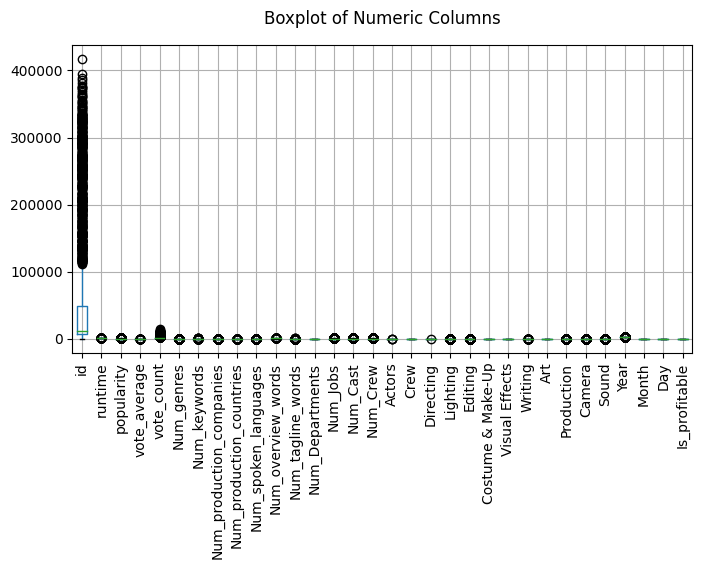

In [123]:
# Plot boxplots for each numeric column
plt.figure(figsize=(8, 4))
clean_movies.drop(columns=['Profit', 'budget']).boxplot()
plt.title('Boxplot of Numeric Columns', pad=15)
plt.xticks(rotation=90)
plt.show()

In [124]:
clean_movies.Is_profitable.value_counts()

Is_profitable
1    2422
0    1270
Name: count, dtype: int64

In [125]:
len(clean_movies[clean_movies.vote_count > 2000])

430

In [126]:
clean_movies[clean_movies.vote_count > 2000].Is_profitable.value_counts()

Is_profitable
1    425
0      5
Name: count, dtype: int64

In [127]:
data = clean_movies[clean_movies['vote_count'] > 2000]

fig = px.histogram(data, x='vote_count', title='Distribution of Vote Counts (Higher than 2000)',
                   color_discrete_sequence=['skyblue'])

fig.update_layout(width=800, height=600, xaxis_title='Vote Count',
                yaxis_title='Frequency', plot_bgcolor='whitesmoke', showlegend=False, title_x=0.5)

iplot(fig)

In [128]:
len(clean_movies[clean_movies['popularity'] >= 300])

6

In [129]:
len(clean_movies[(clean_movies['vote_count'] >= 10000)])

7

In [130]:
clean_movies = clean_movies[clean_movies['vote_count'] < 10000]
clean_movies = clean_movies[clean_movies['popularity'] < 300]

In [131]:
clean_movies.shape

(3681, 35)

#### *Inferences*

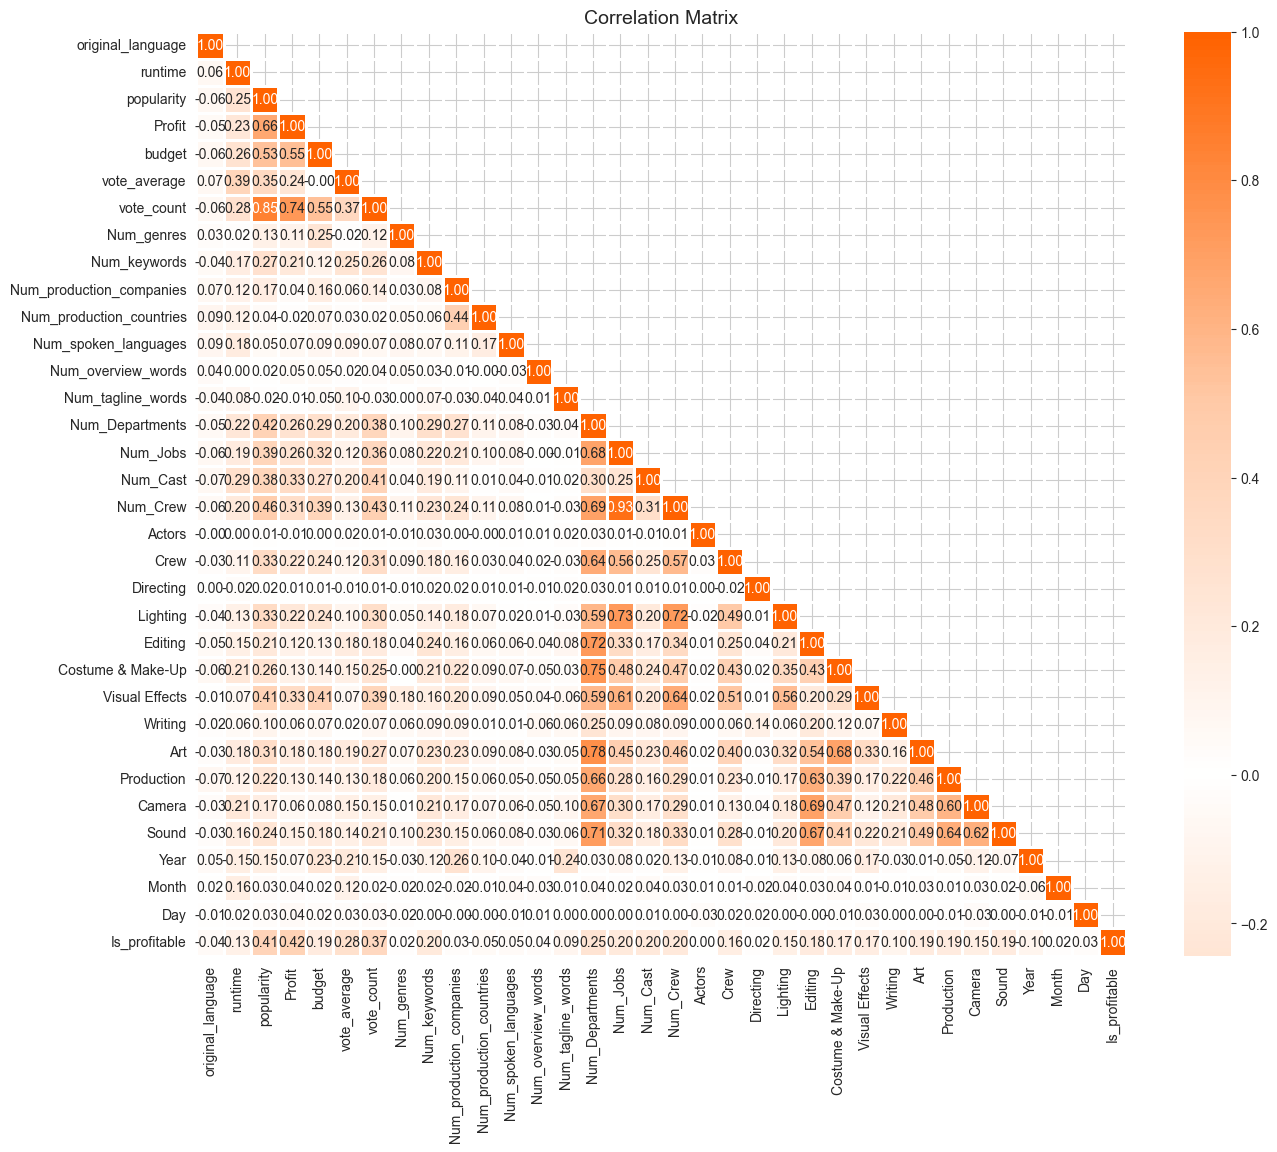

In [132]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix
corr = clean_movies.drop(columns='id').corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

In [133]:
clean_movies.head()

id original_language  runtime  popularity     Profit     budget  \
1     285                 4    169.0  139.082615  661000000  300000000   
2  206647                 4    148.0  107.376788  635674609  245000000   
3   49026                 4    165.0  112.312950  834939099  250000000   
4   49529                 4    132.0   43.926995   24139100  260000000   
5     559                 4    139.0  115.699814  632871626  258000000   

   vote_average  vote_count  Num_genres  Num_keywords  ...  Visual Effects  \
1           6.9        4500           3            16  ...               0   
2           6.3        4466           3             7  ...               1   
3           7.6        9106           4            21  ...               1   
4           6.1        2124           3            16  ...               1   
5           5.9        3576           3            16  ...               0   

   Writing  Art  Production  Camera  Sound  Year  Month  Day  Is_profitable  
1        1    1           1       1      1  2007      5   19              1  
2        1    1           1       1      1  2015     10   26              1  
3        1    1           1       1      1  2012      7   16              1  
4        1    1           1       1      1  2012      3    7              1  
5        1    1           1       1      1  2007      5    1              1  

[5 rows x 35 columns]

In [134]:
clean_movies.dtypes

id                            int64
original_language            object
runtime                     float64
popularity                  float64
Profit                        int64
budget                        int64
vote_average                float64
vote_count                    int64
Num_genres                    int64
Num_keywords                  int64
Num_production_companies      int64
Num_production_countries      int64
Num_spoken_languages          int64
Num_overview_words            int64
Num_tagline_words             int64
Num_Departments               int64
Num_Jobs                      int64
Num_Cast                      int64
Num_Crew                      int64
Actors                        int64
Crew                          int64
Directing                     int64
Lighting                      int64
Editing                       int64
Costume & Make-Up             int64
Visual Effects                int64
Writing                       int64
Art                         

In [135]:
clean_movies['original_language'] = clean_movies['original_language'].astype(int)

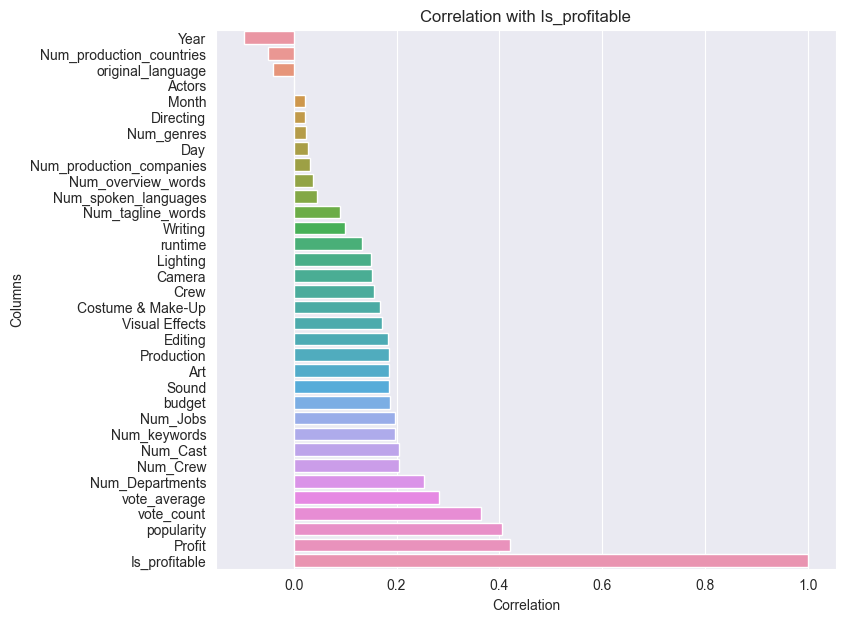

In [136]:
# Calculate correlation of each column with the compare_column
compare_column = 'Is_profitable'
correlation = clean_movies.drop(columns='id').corrwith(clean_movies[compare_column])

# Plot the correlation values
sns.set_style('darkgrid')
plt.figure(figsize=(8,7))
sns.barplot(x=correlation.sort_values().values, y=correlation.sort_values().index)
plt.title(f'Correlation with {compare_column}')
plt.xlabel('Correlation')
plt.ylabel('Columns')
plt.show()

In [137]:
# Creating the scatter plot
fig = px.scatter(clean_movies, x='vote_average', y='vote_count', color=clean_movies['Is_profitable'].map({1: 'Profitable', 0: 'Unprofitable'}),
                 color_discrete_map={'Profitable': 'seagreen', 'Unprofitable': 'crimson'}, 
                 labels={'vote_average': 'Vote Average', 'vote_count': 'Vote Count', 'color': 'Profitability'},
                 category_orders={'color': ['Profitable', 'Unprofitable']})

# Updating layout
fig.update_layout(title='Scatter Plot of Vote Average vs Vote Count',
                  title_x=0.5, plot_bgcolor='whitesmoke',width=900, height=600, 
                  legend=dict(
                      yanchor="top",
                      y=0.99,
                      xanchor="left",
                      x=0.01
                  ))

iplot(fig)

In [138]:
# Creating the scatter plot
fig = px.scatter(clean_movies, x='vote_count', y='popularity', color=clean_movies['Is_profitable'].map({1: 'Profitable', 0: 'Unprofitable'}),
                 color_discrete_map={'Profitable': 'seagreen', 'Unprofitable': 'crimson'}, 
                 labels={'vote_count': 'Vote Count', 'popularity': 'Popularity', 'color': 'Profitability'},
                 category_orders={'color': ['Profitable', 'Unprofitable']})

# Updating layout
fig.update_layout(title='Scatter Plot of Vote Count vs Popularity',
                  title_x=0.5, plot_bgcolor='whitesmoke',width=900, height=600, 
                  legend=dict(
                      yanchor="top",
                      y=0.99,
                      xanchor="left",
                      x=0.01
                  ))

iplot(fig)

In [139]:
# Creating the scatter plot
fig = px.scatter(clean_movies, x='Num_Jobs', y='Num_Departments', color=clean_movies['Is_profitable'].map({1: 'Profitable', 0: 'Unprofitable'}),
                 color_discrete_map={'Profitable': 'seagreen', 'Unprofitable': 'crimson'}, 
                 labels={'color': 'Profitability'},
                 category_orders={'color': ['Profitable', 'Unprofitable']})

# Updating layout
fig.update_layout(title='Plot of Jobs vs Departments',
                  xaxis_title='Number of Jobs', yaxis_title='Number of Departments',
                  title_x=0.5, plot_bgcolor='whitesmoke',width=900, height=600)

iplot(fig)

In [140]:
# Filter and group data
grouped_df = clean_movies.query("2000 <= Year < 2017").groupby(['Year', 'Is_profitable']).size().unstack(fill_value=0)

# Sort years based on total count
sorted_years = grouped_df.sum(axis=1).sort_values(ascending=False).index

# Reorder the DataFrame based on the sorted years
grouped_df = grouped_df.loc[sorted_years]

# Map numeric values to string labels for legend
legend_labels = {1: 'Profitable', 0: 'Unprofitable'}

fig = px.bar(grouped_df.reset_index(), 
             x='Year', 
             y=[1, 0],  # 1 for profitable, 0 for unprofitable
             barmode='group',
             title='Movie Distribution by Release Year and Profitability',
             category_orders={'Year': sorted_years},
             labels={'Year': 'Year', 'value': 'Count', 'variable': 'Profitability'},
             color_discrete_map=legend_labels,  # Map numeric values to legend labels
             color_discrete_sequence=['seagreen', 'crimson'],  # Green for profitable, red for unprofitable
             width=1000, height=550)

fig.update_layout( 
    title_x=0.5,
    bargap=0.4, 
    plot_bgcolor='whitesmoke',
    xaxis=dict(tickmode='linear', dtick=1),
    showlegend=True
)

fig.update_xaxes(showgrid=True)
fig.update_traces(texttemplate='%{y}', textposition='outside')

# Update legend labels
fig.for_each_trace(lambda t: t.update(name=legend_labels[int(t.name[-1])]))

iplot(fig)

In [141]:
clean_movies[clean_movies.Year == 2016]['Is_profitable'].value_counts()

Is_profitable
1    59
0    24
Name: count, dtype: int64

In [142]:
# Filter and group data
grouped_df = clean_movies.groupby(['Month', 'Is_profitable']).size().unstack(fill_value=0)

# Sort months based on total count
sorted_months = grouped_df.sum(axis=1).sort_values(ascending=False).index

# Reorder the DataFrame based on the sorted months
grouped_df = grouped_df.loc[sorted_months]

# Convert month numbers to month names
grouped_df.index = grouped_df.index.map(lambda x: calendar.month_name[x])

# Map numeric values to string labels for legend
legend_labels = {1: 'Profitable', 0: 'Unprofitable'}

fig = px.bar(grouped_df.reset_index(), 
             x='Month', 
             y=[1, 0],  # 1 for profitable, 0 for unprofitable
             barmode='group',
             title='Movie Distribution by Release Month and Profitability',
             category_orders={'Month': calendar.month_name[1:]},  # Use month names in order
             labels={'Month': 'Month', 'value': 'Count', 'variable': 'Profitability'},
             color_discrete_map=legend_labels,  # Map numeric values to legend labels
             color_discrete_sequence=['seagreen', 'crimson'],  # Green for profitable, red for unprofitable
             width=1000, height=550)

fig.update_layout( 
    title_x=0.5,
    bargap=0.4, 
    plot_bgcolor='whitesmoke',
    xaxis=dict(tickmode='linear', dtick=1),
    showlegend=True
)

fig.update_xaxes(showgrid=True)
fig.update_traces(texttemplate='%{y}', textposition='outside')

# Update legend labels
fig.for_each_trace(lambda t: t.update(name=legend_labels[int(t.name[-1])]))

iplot(fig)


In [143]:
fig = px.histogram(clean_movies, x='runtime', marginal='rug', color_discrete_sequence=['purple'], title='Distribution of Runtime')

fig.update_layout(width=900, height=600, xaxis_title='Runtime',
                  yaxis_title='Frequency', title_x=0.5, plot_bgcolor='whitesmoke')

iplot(fig)

In [144]:
clean_movies.columns

Index(['id', 'original_language', 'runtime', 'popularity', 'Profit', 'budget',
       'vote_average', 'vote_count', 'Num_genres', 'Num_keywords',
       'Num_production_companies', 'Num_production_countries',
       'Num_spoken_languages', 'Num_overview_words', 'Num_tagline_words',
       'Num_Departments', 'Num_Jobs', 'Num_Cast', 'Num_Crew', 'Actors', 'Crew',
       'Directing', 'Lighting', 'Editing', 'Costume & Make-Up',
       'Visual Effects', 'Writing', 'Art', 'Production', 'Camera', 'Sound',
       'Year', 'Month', 'Day', 'Is_profitable'],
      dtype='object')

In [145]:
dep_df.columns[:-1]

Index(['Actors', 'Crew', 'Directing', 'Lighting', 'Editing',
       'Costume & Make-Up', 'Visual Effects', 'Writing', 'Art', 'Production',
       'Camera', 'Sound'],
      dtype='object')

In [146]:
clean_movies = clean_movies.drop(columns=['vote_count', 'Num_Jobs'] + list(dep_df.columns[:-1]))

In [147]:
clean_movies.shape

(3681, 21)

In [148]:
clean_movies.drop(columns=['id', 'Profit', 'budget']).head()

original_language  runtime  popularity  vote_average  Num_genres  \
1                  4    169.0  139.082615           6.9           3   
2                  4    148.0  107.376788           6.3           3   
3                  4    165.0  112.312950           7.6           4   
4                  4    132.0   43.926995           6.1           3   
5                  4    139.0  115.699814           5.9           3   

   Num_keywords  Num_production_companies  Num_production_countries  \
1            16                         3                         1   
2             7                         3                         2   
3            21                         4                         1   
4            16                         1                         1   
5            16                         3                         1   

   Num_spoken_languages  Num_overview_words  Num_tagline_words  \
1                     1                  34                  9   
2                     5                  41                  5   
3                     1                  65                  3   
4                     1                  55                  7   
5                     2                  45                  3   

   Num_Departments  Num_Cast  Num_Crew  Year  Month  Day  Is_profitable  
1                9        34        32  2007      5   19              1  
2               11        83       155  2015     10   26              1  
3               11       158       217  2012      7   16              1  
4               11        27       132  2012      3    7              1  
5                9       143        56  2007      5    1              1

In [149]:
clean_movies.drop(columns=['id', 'Profit', 'budget']).to_csv('clean_data.csv', index=False)

#### *Percentage of Profit*

In [150]:
clean_movies['Is_profitable'].value_counts()

Is_profitable
1    2411
0    1270
Name: count, dtype: int64

In [151]:
clean_movies.loc[:, 'Profit_Percentage'] = round((clean_df.loc[:, 'Profit'] / clean_df.loc[:, 'budget']) * 100, 2)

In [152]:
clean_movies.isna().sum()

id                          0
original_language           0
runtime                     0
popularity                  0
Profit                      0
budget                      0
vote_average                0
Num_genres                  0
Num_keywords                0
Num_production_companies    0
Num_production_countries    0
Num_spoken_languages        0
Num_overview_words          0
Num_tagline_words           0
Num_Departments             0
Num_Cast                    0
Num_Crew                    0
Year                        0
Month                       0
Day                         0
Is_profitable               0
Profit_Percentage           0
dtype: int64

In [153]:
clean_movies.dropna(inplace=True)

In [154]:
clean_movies.isna().sum().sum()

0

In [155]:
len(clean_movies[clean_movies['Profit_Percentage'] > 2000])

113

In [156]:
clean_movies = clean_movies[clean_movies['Profit_Percentage'] <= 2000]

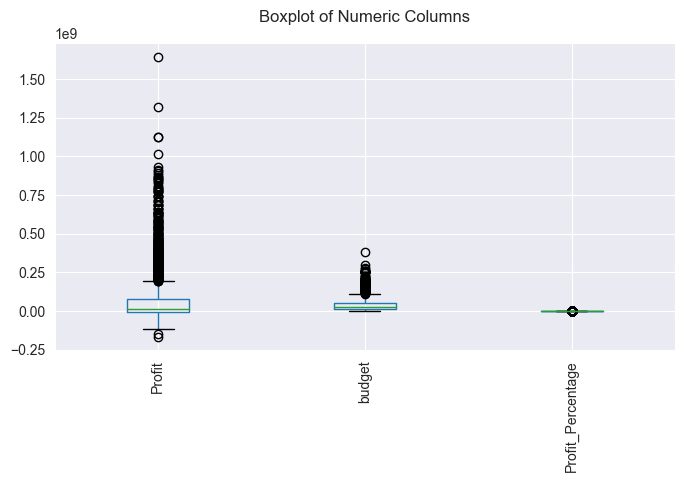

In [157]:
# Plot boxplots for each numeric column
plt.figure(figsize=(8, 4))
clean_movies[['Profit', 'budget', 'Profit_Percentage']].boxplot()
plt.title('Boxplot of Numeric Columns', pad=15)
plt.xticks(rotation=90)
plt.show()

In [158]:
fig = px.histogram(clean_movies, x='Profit_Percentage', marginal='rug', color_discrete_sequence=['green'], title='Distribution of Profit_Percentage')

fig.update_layout(width=900, height=600, xaxis_title='Profit_Percentage',
                  yaxis_title='Frequency', title_x=0.5, plot_bgcolor='whitesmoke')

iplot(fig)

In [159]:
# Define ranges, labels, and corresponding names
ranges = [-float('inf'), -75, -50, -25, 0, 25, 50, 75, 100, float('inf')]
labels = ['-4', '-3', '-2', '-1', '0', '1', '2', '3', '4']
names = ['High Unprofitable', 'Medium Unprofitable', 'Low Unprofitable','Very Low Unprofitable',
          'Very Low Profitable', 'Low Profitable', 'Medium Profitable', 'High Profitable', 'Very High Profitable']

# Create new column 'Profit_Level'
clean_movies['Profit_Level'] = pd.cut(clean_movies['Profit_Percentage'], bins=ranges, labels=labels)

# Map labels to names
clean_movies['Profit_Level_Name'] = clean_movies['Profit_Level'].map(dict(zip(labels, names)))

clean_movies.head()

id  original_language  runtime  popularity     Profit     budget  \
1     285                  4    169.0  139.082615  661000000  300000000   
2  206647                  4    148.0  107.376788  635674609  245000000   
3   49026                  4    165.0  112.312950  834939099  250000000   
4   49529                  4    132.0   43.926995   24139100  260000000   
5     559                  4    139.0  115.699814  632871626  258000000   

   vote_average  Num_genres  Num_keywords  Num_production_companies  ...  \
1           6.9           3            16                         3  ...   
2           6.3           3             7                         3  ...   
3           7.6           4            21                         4  ...   
4           6.1           3            16                         1  ...   
5           5.9           3            16                         3  ...   

   Num_Departments  Num_Cast  Num_Crew  Year  Month  Day  Is_profitable  \
1                9        34        32  2007      5   19              1   
2               11        83       155  2015     10   26              1   
3               11       158       217  2012      7   16              1   
4               11        27       132  2012      3    7              1   
5                9       143        56  2007      5    1              1   

   Profit_Percentage  Profit_Level     Profit_Level_Name  
1             220.33             4  Very High Profitable  
2             259.46             4  Very High Profitable  
3             333.98             4  Very High Profitable  
4               9.28             0   Very Low Profitable  
5             245.30             4  Very High Profitable  

[5 rows x 24 columns]

In [160]:
print('Profit_Level')
for i in range(-4, 5):
    print(f"{i}: ({clean_movies[clean_movies['Profit_Level']== str(i)]['Profit_Percentage'].min()}, "
          f"{clean_movies[clean_movies['Profit_Level']== str(i)]['Profit_Percentage'].max()})")

Profit_Level
-4: (-100.0, -75.0)
-3: (-74.99, -50.0)
-2: (-49.98, -25.34)
-1: (-24.69, 0.0)
0: (0.09, 24.73)
1: (25.07, 50.0)
2: (50.17, 75.0)
3: (75.01, 100.0)
4: (100.04, 1971.81)


In [161]:
clean_movies['Profit_Level'].value_counts().sort_index()

Profit_Level
-4     703
-3     192
-2     183
-1     192
0      180
1      148
2      151
3      151
4     1668
Name: count, dtype: int64

In [162]:
merged_df = clean_movies[['id', 'Profit_Level']].merge(genres_df.drop(columns=['title', 'Is_profitable']), on='id', how='inner')

In [163]:
# Drop 'title' column
temp_df = merged_df.drop(['id'], axis=1)

# Count profitable and unprofitable movies for each department
counts_df = temp_df.groupby('Profit_Level', observed=True).sum().T.reset_index()

# Melt DataFrame to have 'Profit_Level' as a variable
melted_df = pd.melt(counts_df, id_vars='index', var_name='Profit_Level', value_name='Count')

# Sort values based on count and Profit_Level
melted_df = melted_df.sort_values(by=['Profit_Level', 'Count'], ascending=[False, False])

# Map 'Profit_Level' values to labels
melted_df['Profit_Level'] = melted_df['Profit_Level'].map(dict(zip(labels, names)))

# Define custom color scales for green and red
green_scale = px.colors.sequential.Greens  # Using a sequential green color scale from Plotly Express
red_scale = px.colors.sequential.Reds  # Using a sequential red color scale from Plotly Express

# Custom color scale mapping
color_map = {
    'Very High Profitable': green_scale[-1],  
    'High Profitable': green_scale[6],       
    'Medium Profitable': green_scale[4],     
    'Low Profitable': green_scale[2],        
    'Very Low Profitable': green_scale[1],  
    'High Unprofitable': red_scale[-1],       
    'Medium Unprofitable': red_scale[6],     
    'Low Unprofitable': red_scale[4],        
    'Very Low Unprofitable': red_scale[1],  
}


# Create a grouped bar plot
fig = px.bar(melted_df, x='index', y='Count', color='Profit_Level',
             color_discrete_map=color_map,
             barmode='group',
             title='Profitable and Unprofitable movies by genre',
             text='Count', # Display count on bars
             )

# Update layout and trace properties
fig.update_layout(width=2000, height=600, 
                  xaxis_title="Genre",
                  yaxis_title="Count", 
                  title_x=0.5,
                  bargap=0.4, 
                  plot_bgcolor='whitesmoke',
                  legend_title='Profitability')

# Display count on each bar
fig.update_traces(texttemplate='%{text}', textposition='outside')

iplot(fig)

In [164]:
merged_df[merged_df['Drama'] == 1]['Profit_Level'].map(dict(zip(labels, names))).value_counts()

Profit_Level
Very High Profitable     684
High Unprofitable        386
Very Low Unprofitable    103
Medium Unprofitable      100
Low Unprofitable          97
Very Low Profitable       88
Medium Profitable         71
High Profitable           62
Low Profitable            57
Name: count, dtype: int64

In [165]:
# Create a new dictionary with keys and values swapped
label_mapping = {value: key for key, value in label_mapping.items()}

# Convert the dictionary to a DataFrame
df_language = pd.DataFrame(list(label_mapping.items()), columns=['language_id', 'language'])

# Create a DataFrame with profit data
df_profit = pd.DataFrame([{'profit_id': 1, 'profit': 'Profitable'}, {'profit_id': 0, 'profit': 'Unprofitable'}])

# Write each DataFrame to a different sheet
df_language.to_csv('Dimension1.csv', index=False)
df_profit.to_csv('Dimension2.csv', index=False)